In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["image.cmap"] = "RdBu_r"

In [2]:
def get_tauCC(eta, tau_PM, c):
    return (1.-eta)**(1./c) * tau_PM

In [113]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = 0.01
blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
eta_CC, tau_PM, c_CC = 0.5, 0.005, 1.
tau_CC = get_tauCC(eta_CC, tau_PM, c_CC)
print eta_CC, tau_CC, c_CC
eta = np.zeros(mesh.nC)
eta[blkind] = eta_CC
tau = np.ones(mesh.nC) * tau_CC
c = np.ones(mesh.nC) * c_CC 

0.5 0.0025 1.0


In [114]:
from simpegEMIP.SeogiUtils.View import Rectangle2D

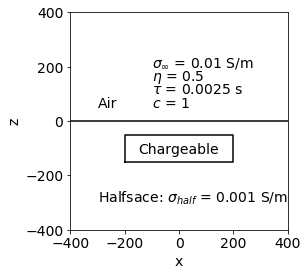

In [194]:
fig = plt.figure()
mesh.plotImage(eta*np.nan, mirror=True)
plt.xlim(-400, 400)
plt.ylim(-400, 400)
xy_box = Rectangle2D(np.r_[0, -100], 400, 100)
xy_surface = np.c_[np.r_[-400, 400], np.r_[0, 0]]
plt.plot(xy_box[:,0], xy_box[:,1], 'k-')
plt.plot(xy_surface[:,0], xy_surface[:,1], 'k-')
plt.gca().set_aspect("equal")
plt.text(-300., 50., "Air")
plt.text(-300., -300, "Halfsace: $\sigma_{half}$ = 0.001 S/m")
plt.text(-150., -120, "Chargeable")
plt.text(-100., 350-150, "$\sigma_{\infty}$ = 0.01 S/m")
plt.text(-100., 300-150, "$\eta$ = 0.5")
plt.text(-100., 250-150, "$\\tau$ = 0.0025 s")
plt.text(-100., 200-150, "$c$ = 1")
fig.savefig("model", dpi=300)

In [116]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])

In [117]:
from simpegEMIP.TDEM import Problem3D_e, BaseTDEMIPProblem
from simpegEMIP.Base import BaseEMIPProblem

In [137]:
rx_emip = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = EM.TDEM.Survey([src])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
F = prb_emip.fields(m)
data = survey_emip.dpred(m, f=F)

In [148]:
rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_em = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_em = EM.TDEM.Survey([src])
prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey_em)
m = np.r_[sigmaInf, eta, tau, c]
data_em = survey_em.dpred(m)

In [150]:
data_ip = data - data_em

In [228]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy
# ms = 1e3
rectpts = rect2D([0.3, 1e-14],[3., 1e-6])
# print tc[5], tc[15]

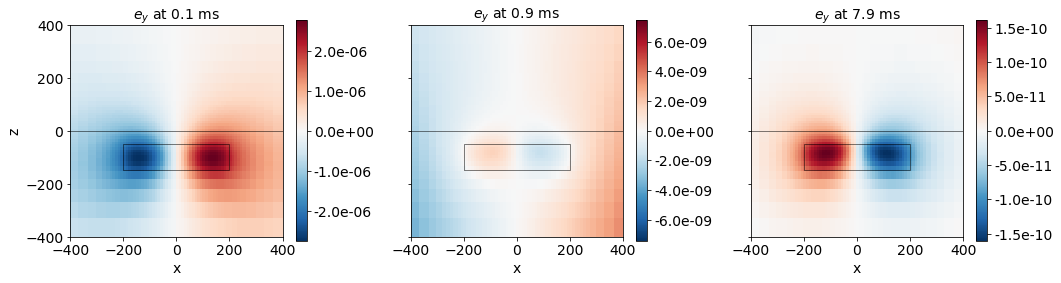

In [247]:
fig, axs = plt.subplots(1,3, figsize = (15, 4))
ms = 1e-3
tc = np.r_[0.1, 0.9, 8] * ms
tInds = []
for i, ax in enumerate(axs):
    tInd = int(np.argmin(abs(prb_em.times-tc[i])))
    tInds.append(tInd)
    cb = plt.colorbar(mesh.plotImage(F[src, 'eSolution', tInd], mirror=True, vType="E", ax=ax)[0], format = "%.1e", ax=ax)
    ax.set_xlim(-400, 400)
    ax.set_ylim(-400, 400)
    ax.set_aspect("equal")
    if i>0:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.plot(xy_box[:,0], xy_box[:,1], 'k-', lw=1, alpha=0.5)
    ax.plot(xy_surface[:,0], xy_surface[:,1], 'k-', lw=1, alpha=0.5)        
    ax.set_title(("$e_y$ at %.1f ms")%(prb_em.times[tInd] * 1e3), fontsize = 14)
plt.tight_layout()
fig.savefig("efields", dpi=300)

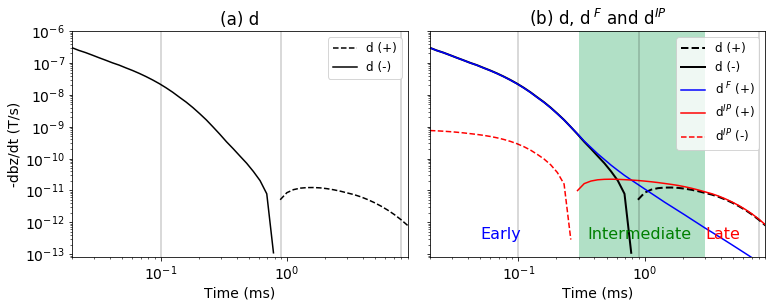

In [250]:
fig, axs = plt.subplots(1,2, figsize = (11, 4.5))
ms = 1e3
axs[0].loglog(rx.times*ms, data.flatten(), 'k--')
axs[0].loglog(rx.times*ms, -data.flatten(), 'k-')
axs[0].legend(("d (+)", "d (-)", "d$^{\ F}$ (+)"), fontsize = 12, loc=1)

axs[1].loglog(rx.times*ms, data.flatten(), 'k--', lw=2)
axs[1].loglog(rx.times*ms, -data.flatten(), 'k-', lw=2)
axs[1].loglog(rx.times*ms, -data_em.flatten(), 'b-')
axs[1].loglog(rx.times*ms, data_ip.flatten(), 'r-')
axs[1].loglog(rx.times*ms, -data_ip.flatten(), 'r--')
axs[1].legend(("d (+)", "d (-)", "d$^{\ F}$ (+)","d$^{IP}$ (+)", "d$^{IP}$ (-)"), fontsize = 12)
for ax in axs:
#     ax.grid(True, which='major')
    ax.set_xlabel("Time (ms)")    
    ax.set_xlim(rx.times.min()*ms, rx.times.max()*ms)
    ax.set_ylim(8e-14, 1e-6)
for t in tc:
    axs[0].loglog(np.ones(2)*t*ms, np.r_[8e-14, 1e-6], 'k-', alpha=0.2)
    axs[1].loglog(np.ones(2)*t*ms, np.r_[8e-14, 1e-6], 'k-', alpha=0.2)
axs[0].set_ylabel("-dbz/dt (T/s)")
axs[1].set_yticklabels([])
axs[0].set_title("(a) d")
axs[1].set_title("(b) d, d$^{\ F}$ and d$^{IP}$")

patches = []
polygon = mpatches.Polygon(rectpts, True)
patches.append(polygon)
p = PatchCollection(patches, cmap=matplotlib.cm.jet, facecolors=["mediumseagreen"], alpha=0.4)
ax.add_collection(p)
ax.text(0.05,  3e-13, "Early", color="blue", fontsize = 16)
ax.text(0.35,  3e-13, "Intermediate", color="green", fontsize = 16)
ax.text(3., 3e-13, "Late", color="red", fontsize = 16)
plt.tight_layout()
fig.savefig("data", dpi=300)